# Tabular Data Classification Example

In this example, we demonstrate how to use dlpy to build a simple neural network for tabular data classification problems. 

The breast cancer dataset we used here is contained in the sklearn package. More details about the data can be found here:https://scikit-learn.org/stable/datasets/index.html#breast-cancer-dataset

Key steps involved:
1. Upload data to the server
2. Build and train a fully connected feedforward neural network model with dlpy.
3. Predict on the testing dataset.
4. Evaluate confusion matrix
5. Assess and visualize ROC curve, calculate Area under the curve(AUC). 

### 1. Import python modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.datasets import load_breast_cancer #The dataset is from sklearn package, with version >= 0.20.1
from swat.cas import datamsghandlers
from swat import CAS, CASTable
from dlpy import Model, Sequential
from dlpy.model import Optimizer, AdamSolver
from dlpy.layers import * 
%matplotlib inline

### 2. Connect to CAS server

In [2]:
conn = CAS(host_name, port_number)

### 3. Load examples dataset from scikit-learn

In [3]:
# load the breast cancer data
bc_data = load_breast_cancer() 

# Get data into two pandas dataframes for the predictors(bc_x_df) and target(bc_y_df). 
bc_x_df = pd.DataFrame(bc_data['data'], columns=bc_data['feature_names'])
bc_y_df = pd.DataFrame(bc_data['target'], columns=['target_class'])

# Concatenate the data into one dataframe
bc_df = pd.concat([bc_x_df, bc_y_df], axis=1)

In [4]:
bc_df.loc[:10]

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target_class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.26540,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.18600,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.24300,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.25750,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.16250,0.2364,0.07678,0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.17410,0.3985,0.12440,0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.19320,0.3063,0.08368,0
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.15560,0.3196,0.11510,0
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.20600,0.4378,0.10720,0
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.22100,0.4366,0.20750,0


There are 212 malignant tumors ('0' in the data), 357 benign tumors ('1' in the data)

In [5]:
bc_df.target_class.value_counts()

1    357
0    212
Name: target_class, dtype: int64

### 4. Upload the pandas dataframe to server

In [6]:
handler = datamsghandlers.PandasDataFrame(bc_df)
conn.addtable(table='bc_df', replace=True, **handler.args.addtable)
tbl = conn.CASTable(name='bc_df')

### 5. Split the data

Here we show the train-test spliting using the 'sampling' action in CAS. It is a preferred method, if the data is large and hosted on the server side. 

In [7]:
# load the sampling action set
conn.loadactionset(actionSet='sampling', _messagelevel='error')

# do random sampling, and add a new ('partind') column to the original table.
# partind column have randomly selected 30% entries marked as indicator 1 for testing, 
# and the rest 70% are marked as 0 for training
sample_result = conn.sampling.srs(tbl, sampPct=30, 
                                  partInd=True, seed=1234,
                                  output={'casOut':{'name':tbl.name, 'replace':True}, 
                                          'copyVars':'ALL', 'partIndName':'partind'})

# get the train and test dataset
train_tbl = tbl.query('partind = 0')
test_tbl = tbl.query('partind = 1')

NOTE: Using SEED=1234 for sampling.


### 6. Build one layer fully connected neural network

Network specifications:
1. One dense layer
2. Activation function: relu
3. Number of neurons: 20
4. Output layer loss function: entropy.
5. Output layer activation function: softmax (to match with entropy).
6. number of neuron in output layer: n=2 (two classes).

In [8]:
model1 = Sequential(conn, model_table=CASTable('simple_dnn_classifier', replace=True))
model1.add(InputLayer(std='STD'))
model1.add(Dense(20, act='relu'))
model1.add(OutputLayer(act='softmax', n=2,  error='entropy'))

NOTE: Input layer added.
NOTE: Fully-connected layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


### 7. Train fully connected neural network

Here we specify the optimizer to show a **scheduled training approach**:

We use `learning_rate_policy='step'` to specify stepwise learning rate decreasing policy. The step size is `step_size=5`, which means every 5 epochs, the `learning_rate` will be multiplied by factor `gamma=0.9`. In addition, we set `log_level=2` to visualize the training log.

In [9]:
optimizer = Optimizer(algorithm=AdamSolver(learning_rate=0.001, learning_rate_policy='step', gamma=0.9, step_size=5),
                      mini_batch_size=4, seed=1234, max_epochs=50, log_level=2)

result = model1.fit(train_tbl, inputs=bc_x_df.columns.tolist(), nominals=['target_class'], 
           target='target_class', optimizer=optimizer)

NOTE: Training from scratch.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 662.
NOTE:  The approximate memory cost is 1.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.01 (s).
NOTE:  The total number of threads on each worker is 32.
NOTE:  The total mini-batch size per thread on each worker is 4.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 128.
NOTE:  Target variable: target_class
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0:            0
NOTE:  Level      1:            1
NOTE:  Number of input variables:    30
NOTE:  Number of numeric input variables:     30
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0         0.001          0.5993     0.3116     0.01
NOTE:  1         0.001          0.2034    0.03015     0.01
NOTE:  2         0.001          0.1277    0.02764     0.01
NOTE:  

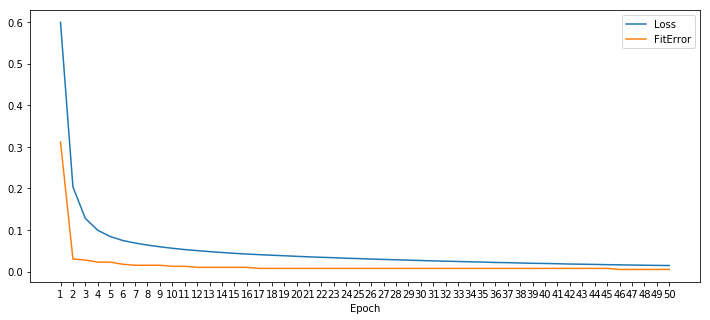

In [10]:
# Plot the training history.
model1.plot_training_history()

### 8. Predict the test data set

In [11]:
result = model1.predict(test_tbl)
resulttbl = model1.valid_res_tbl

### 9. Show the confusion matrix

In [12]:
# Use the crosstab functionality to show the confusion matrix
# the real target is in 'target_class', the predicted target is in 'I_target_class'
crosstab_result = model1.conn.crosstab(resulttbl, row='target_class', col='I_target_class')
con_matrix = crosstab_result['Crosstab']
display(con_matrix)

,target_class,Col1,Col2
0,0,71.0,7.0
1,1,1.0,92.0


### 10. Use percentile.assess generate ROC curve 

In [13]:
# Load actionset
conn.loadactionset(actionSet='percentile', _messagelevel='error')

# resulttbl is the CASTable object of the predicted results
# inputs is the predicted class probability
# respons is the target class label
# event specifies the positive event
# cutstep is the incremental step size of probability cutoff
roc_res = conn.percentile.assess(resulttbl, inputs=['P_target_class1'], response='target_class', 
                                 event='1', cutstep=0.001)

In [14]:
roc = roc_res['ROCInfo']

# False positive rate, add the 0 point to the list, since the original doesn't have cutoff value = 1
FPR = list(roc.FPR) + [0]
# True positive rate, add the 0 point to the list, since the original doesn't have cutoff value = 1
TPR = list(roc.Sensitivity) + [0]

Text(0.5,1,'ROC curve')

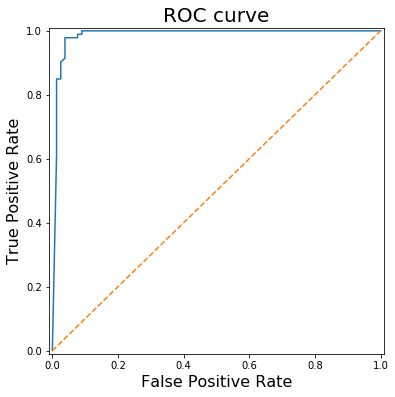

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(FPR, TPR)
ax.set_ylim([-0.01, 1.01])
ax.set_xlim([-0.01, 1.01])
ax.plot([0,1], [0,1], linestyle='--')
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title('ROC curve', fontsize=20)

In [16]:
AUC = roc.C.loc[0]
print('The area under the curve is: {:.4f}'.format(AUC))

The area under the curve is: 0.9870
